# XAI Tutorial of Gianni Franchi Rémi KAZMIERCZAK
**PLEASE write your name and first name here:**

RUBACK Arthur

LOPEZ Vanessa

SANO Matheus

Welcome to your XAI project!
**In this notebook, you will**:
- Learn  about classification
- Learn about XAI
- Learn about CLIP
- Learn what are Concept Bottleneck Models (CBMs)


If you have never used jupyter notebooks, nor Colab notebooks, [here](https://colab.research.google.com/notebooks/welcome.ipynb) is a short intro.

In [ ]:
# @title Global Parameters
retrain_networks = False # @param {type:"boolean"}
biased_dataset = False # @param {type:"boolean"}



## 0 Visualisation of the dataset


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/MyDrive/Colab Notebooks/IA323/'


Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1vE3NXwcxvay29tC5L4LsCOWGZw84ocX9/IA323


In [ ]:
download = False
if download:
  # First we download the dataset. In order to have fast download please use this command line
  !pip install gdown

  !gdown 1FMuha-TWKVrCZY4_LG8abk5PMTxZYU_5
  !unzip Cats_Dogs_Cars_Reduced.zip

We have constructed a dataset that includes images of black and white dogs, cars, and cats. The dataset consists of three classes: **cats**, **dogs**, and **cars**. To have a better understanding of the DNN biais, we've organized explicit folders for each color within each class. This arrangement allows us to explore whether the Deep Neural Network (DNN) relies solely on color information for classification, enabling us to train and evaluate the model with images of a single multiple colors.

In [ ]:
import glob
from PIL import Image
import torch
import numpy as np
from torchvision.models import resnet50, ResNet50_Weights
from tqdm import tqdm
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F

### Version Fusionée

class Cats_Dogs_dataset_x(torch.utils.data.Dataset):
  # Cats_Dogs_dataset (torch dataset)

  def __init__(self,root,phase,preprocess,device='cuda',set_dogs='Black+White',set_cats='Black+White',
               set_cars='Black+White'):
    super(Cats_Dogs_dataset_x, self).__init__()

    '''
    Cats and dogs dataset + some tools to create usefuls subdatasets
    root: Root of the data (/.../semanticPascalPart)
    phase: Phase of the learning in ['train','val','test']
    shuffle: Shuffle the dataset items
    device: Gpu (or cpu) to use
    save_mode: after precomputing the images, save this as npy files
    '''

    self.preprocess = preprocess
    self.device = device
    self.List_classes = ['Dogs','Cats','Cars']
    self.info_dataset = {'Dogs':set_dogs.split('+'),'Cats':set_cats.split('+'),'Cars':set_cars.split('+')}
    self.img_paths = []
    self.labels = []

    # New version save npy files

    for pet_class in ['Dogs','Cats','Cars']:
      for color in self.info_dataset[pet_class] :
        paths_images_subset = sorted(glob.glob(root+'/'+pet_class+'/'+color+'/*.jpg'))
        imgs_train_subset,imgs_val_subset,imgs_test_subset = self.split_dataset(paths_images_subset)
        if phase == 'train':
          self.img_paths+=imgs_train_subset
          self.labels+=[self.List_classes.index(pet_class) for i in range(len(imgs_train_subset))]

        if phase == 'test':
          self.img_paths+=imgs_val_subset
          self.labels+=[self.List_classes.index(pet_class) for i in range(len(imgs_val_subset))]

        if phase == 'val':
          self.img_paths+=imgs_test_subset
          self.labels+=[self.List_classes.index(pet_class) for i in range(len(imgs_test_subset))]

  def split_dataset(self,img_ids,split_seed=-1):

    if split_seed != -1 :

      np.random.seed(split_seed)
      np.random.shuffle(img_ids)

    l = len(img_ids)

    img_ids_train = img_ids[:int(l * 0.6)]
    img_ids_test = img_ids[int(l * 0.6):int(l * 0.8)]
    img_ids_val = img_ids[int(l * 0.8):]

    return img_ids_train, img_ids_val, img_ids_test

    return label_to_return

  def __len__(self):
    return len(self.img_paths)

  def __getitem__(self,index):

    path = self.img_paths[index]
    img = Image.open(path)

    img_tensor= self.preprocess(img)
    img_tensor = img_tensor.to(self.device)

    label = self.labels[index]

    return {'input':img_tensor,'label':label,'path':path}

  def get_target(self, target):

    return (
        np.argwhere(np.array(self.labels) == target + 1)
        .reshape(-1)
        .tolist()
    )



In [ ]:
all_color = not(biased_dataset)
color_white = biased_dataset #  please play with the color to build biais or not
if all_color:
  # generation of the dataloader for the 3 classes with all the color
  D_set_dogs = {'train':'Black+White','val':'Black+White','test':'Black+White'}
  D_set_cats = {'train':'Black+White','val':'Black+White','test':'Black+White'}
  D_set_cars = {'train':'Black+White','val':'Black+White','test':'Black+White'}

  #root = '/content/drive/MyDrive/Cours/TP_XAI/Dataset'
  root = 'Cats_Dogs_Cars_Reduced'

  weights = ResNet50_Weights.DEFAULT
  preprocess_resnet = weights.transforms()

  Cats_Dogs_dataset_x_train = Cats_Dogs_dataset_x(root,'train',preprocess_resnet,set_dogs=D_set_dogs['train'],set_cats=D_set_cats['train'],set_cars=D_set_cars['train'])
  Cats_Dogs_dataset_x_val = Cats_Dogs_dataset_x(root,'val',preprocess_resnet,set_dogs=D_set_dogs['val'],set_cats=D_set_cats['val'],set_cars=D_set_cars['val'])
  Cats_Dogs_dataset_x_test = Cats_Dogs_dataset_x(root,'test',preprocess_resnet,set_dogs=D_set_dogs['test'],set_cats=D_set_cats['test'],set_cars=D_set_cars['test'])



  dataloader_train = torch.utils.data.DataLoader(Cats_Dogs_dataset_x_train,shuffle=True,batch_size=64)
  dataloader_val = torch.utils.data.DataLoader(Cats_Dogs_dataset_x_val,shuffle=True,batch_size=64)
  dataloader_test = torch.utils.data.DataLoader(Cats_Dogs_dataset_x_test,shuffle=False,batch_size=64)
elif color_white:
  # generation of the dataloader for the 3 classes with all the color
  D_set_dogs = {'train':'White','val':'White','test':'Black+White'}
  D_set_cats = {'train':'White','val':'White','test':'Black+White'}
  D_set_cars = {'train':'White','val':'White','test':'Black+White'}
  #  D_set_cars = {'train':'','val':'','test':'Black+White'} si on veu s'entrainer sur aucune classe

  # root = '/content/drive/MyDrive/Cours/TP_XAI/Dataset'
  root = 'Cats_Dogs_Cars_Reduced'

  weights = ResNet50_Weights.DEFAULT
  preprocess_resnet = weights.transforms()

  Cats_Dogs_dataset_x_train = Cats_Dogs_dataset_x(root,'train',preprocess_resnet,set_dogs=D_set_dogs['train'],set_cats=D_set_cats['train'],set_cars=D_set_cars['train'])
  Cats_Dogs_dataset_x_val = Cats_Dogs_dataset_x(root,'val',preprocess_resnet,set_dogs=D_set_dogs['val'],set_cats=D_set_cats['val'],set_cars=D_set_cars['val'])
  Cats_Dogs_dataset_x_test = Cats_Dogs_dataset_x(root,'test',preprocess_resnet,set_dogs=D_set_dogs['test'],set_cats=D_set_cats['test'],set_cars=D_set_cars['test'])

  dataloader_train = torch.utils.data.DataLoader(Cats_Dogs_dataset_x_train,shuffle=True,batch_size=64)
  dataloader_val = torch.utils.data.DataLoader(Cats_Dogs_dataset_x_val,shuffle=True,batch_size=64)
  dataloader_test = torch.utils.data.DataLoader(Cats_Dogs_dataset_x_test,shuffle=False,batch_size=64)

## 1 Classical Supervised Classification with Resnet 50

You work now with Resnet 50, but when we work with CLIP you will work with ViT
**question 0 :  Why we do not use here ViT?**

The Vision Transformer (ViT) is a transformer-based neural network architecture for computer vision tasks such as image recognition. ResNet 50, in its turn, is a convolutional neural network (CNN) architecture that features residual blocks with skip connections to mitigate the problem of gradient vanishing.

ViT can have a much larger number of parameters compared to ResNet 50, as it processes information globally and may need more capacity to capture complex patterns in images. In this way, ResNet 50 is a simpler model, with fewer parameters prone to overfitting.

In addition, ViT processes global information with self-attention and can capture long-range dependencies throughout the image. However, the convolutional nature of ResNet 50 is more suitable for our case, as we aim to capture local patterns in images, requiring fewer computational resources than ViT.

In [ ]:
# Define the model and the optimizer

class resnet50_classif(nn.Module):
	def __init__(self,device, output_dim,Freeze_backbone=True):
		super().__init__()
		self.Freeze_backbone = Freeze_backbone
		resnet50_all = resnet50(weights=ResNet50_Weights.DEFAULT).to(device)
		self.resnet50 = torch.nn.Sequential(*(list(resnet50_all.children())[:-1]))
		self.linear = nn.Linear(2048, output_dim)

	def forward(self, x):
		if self.Freeze_backbone :
			with torch.no_grad() :
				x = self.resnet50(x)
		else :
			x = self.resnet50(x)
		x = x.squeeze(-1).squeeze(-1)
		x = self.linear(x)
		x = F.softmax(x)

		return x


In [ ]:
# Function for training the model
def train_model(model, dataloader, criterion, optimizer,device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data in tqdm(dataloader, desc='Training'):
        inputs = data['input'].to(device)
        labels = data['label'].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward(retain_graph=True)
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(dataloader)
    train_acc = 100. * correct / total
    return train_loss, train_acc

# Function for evaluating the model
def evaluate_model(model, dataloader, criterion,device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
      for data in tqdm(dataloader, desc='Evaluating'):
            inputs = data['input'].to(device)
            labels = data['label'].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = running_loss / len(dataloader)
    val_acc = 100. * correct / total
    return val_loss, val_acc


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

List_classes = ['Dogs','Cats','Cars']

model = resnet50_classif(device,len(List_classes),Freeze_backbone=False)
model.to(device)

'''import torchvision.models as models
# Define your ResNet50 model
model = models.resnet50(pretrained=True).to(device)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3).to(device)'''

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 10  # Set your desired number of epochs

best_score = 0

train = retrain_networks
if train:
  for epoch in range(num_epochs):
      train_loss, train_acc = train_model(model,dataloader_train, criterion, optimizer,device)
      val_loss, val_acc = evaluate_model(model, dataloader_val, criterion,device)
      print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")

      if val_acc > best_score :
        best_epoch = epoch
        best_score = val_acc
        if not biased_dataset:
          torch.save(model,'best_model_run_resnet50.pth')
        else:
          torch.save(model,'best_model_run_resnet50_biased.pth')

# Test the trained model
if not biased_dataset:
  best_model = torch.load('best_model_run_resnet50.pth').to(device)
else:
  best_model = torch.load('best_model_run_resnet50_biased.pth').to(device)

if train:
  test_loss, test_acc = evaluate_model(best_model, dataloader_test, criterion,device)
  print('Best Epoch',best_epoch)
  print(f"Test Loss: {test_loss:.4f} - Test Acc: {test_acc:.2f}%")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 165MB/s]


**Question 1: Try applying [Class Activation Maps](http://cnnlocalization.csail.mit.edu/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf) (CAMs) to enhance the interpretability of the classification results. (if you prefere you can use GradCam)**

**Question 2: What do you think about the quality of the explanation of your classification.** (hint show cases where the CAM is not good enough)

The explanation, as seen on the next figure, seems very good, localizing the important parts of the class in the images. However, we can see that for images where the class occupies most of the image, only a certain part (which is the most significant for the CNN) is highlighted.

In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 16.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.0-py3-none-any.whl size=38070 sha256=747db705c8218582c43da9cd21784d37b344327df35d5275d7e58e8efd7afd92
  Stored in directory: /root/.cache/pip/wheels/5b/e5/3d/8548241d5cffe53ad1476c566a61ad9bf09cc61a9430f09726
Successfully built grad-cam


  0%|          | 0/1 [00:07<?, ?it/s]
<ipython-input-6-27dec5fefd70>:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


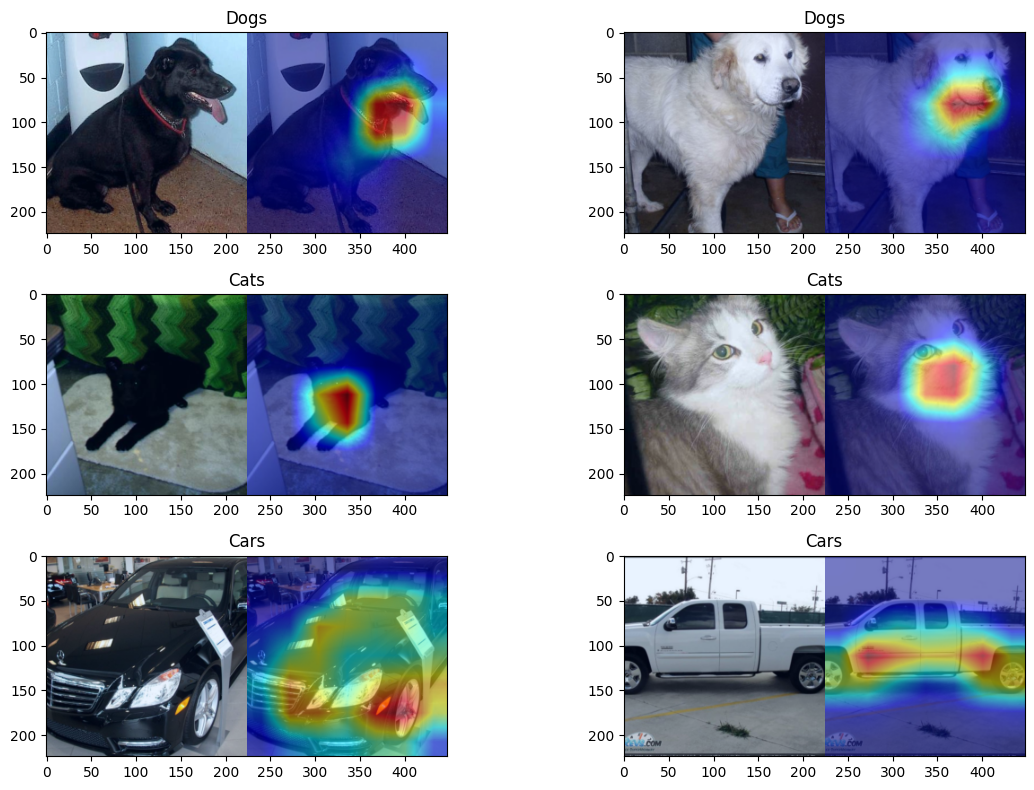

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
import cv2
from PIL import Image
import requests
import matplotlib.pyplot as plt

target_layers = [best_model.resnet50[7]]

dataloader_gradcam = torch.utils.data.DataLoader(Cats_Dogs_dataset_x_test,shuffle=False,batch_size=1000)

for data in tqdm(dataloader_gradcam):
  inputs = data['input']
  break

input_tensor = inputs

# black dog 10
# white dog 120
# black cat 35
# white cat 400
# black car 500
# white car 630
indices = [10, 120, 35, 400, 500, 630]
labels = [0, 0, 1, 1, 2, 2]

fig, axs = plt.subplots(3, 2, figsize=(12, 8))

# Construct the CAM object
with GradCAM(model=best_model, target_layers=target_layers) as cam:
  for ind, lab, i in zip(indices, labels, range(6)):
    img = np.array(inputs[ind].cpu())
    img = img.transpose(1, 2, 0)
    img32 = np.float32(img) / (img.max() - img.min())
    scaled_image = (img32 - img32.min()) / (img32.max() - img32.min())
    original_image = (scaled_image * 255).astype(np.uint8)

    targets = [ClassifierOutputTarget(lab)]
    grayscale_cams = cam(input_tensor=input_tensor[ind:ind+1,:,:,:], targets=targets)
    cam_image = show_cam_on_image(scaled_image, grayscale_cams[0, :], use_rgb=True)
    images = np.hstack((original_image, cam_image))

    row_index = i // 2
    col_index = i % 2
    axs[row_index, col_index].imshow(images, vmin=0, vmax=255)
    axs[row_index, col_index].set_title(List_classes[lab])

plt.tight_layout()
plt.show()

The explanation, as seen on the next figure, seems very good, localizing the important parts of the class in the images. However, we can see that for images where the class occupies most of the image, only a certain part (which is the most significant for the CNN) is highlighted.

## 2 : Zeros Shot Classification with CLIP

CLIP (Contrastive Language-Image Pre-training) is a Foundation model developed by OpenAI that has garnered attention for its ability to perform zero-shot classification effectively. Zero-shot classification refers to the capability of a model to recognize and categorize objects or concepts it has never seen during training. CLIP achieves this by bridging the gap between vision and language.

At its core, CLIP is a vision-language model that learns to associate images and their corresponding textual descriptions. Unlike traditional models that rely solely on image data, CLIP is trained on a diverse set of internet images paired with natural language descriptions. This unique training approach allows CLIP to understand the context and relationships between images and their associated textual descriptions.

The key to CLIP's success in zero-shot classification lies in its ability to comprehend textual prompts. During inference, instead of relying solely on visual information, CLIP leverages its knowledge of language to understand the task at hand. This means that users can input textual descriptions or queries to guide CLIP in making predictions about images it has never encountered before.

For example, if CLIP is trained on images of various dog breeds with corresponding textual descriptions, it can successfully classify a new image of a dog even if it has not seen that specific breed during training. By understanding the language associated with images, CLIP generalizes well to novel scenarios, making it a powerful tool for zero-shot classification tasks.


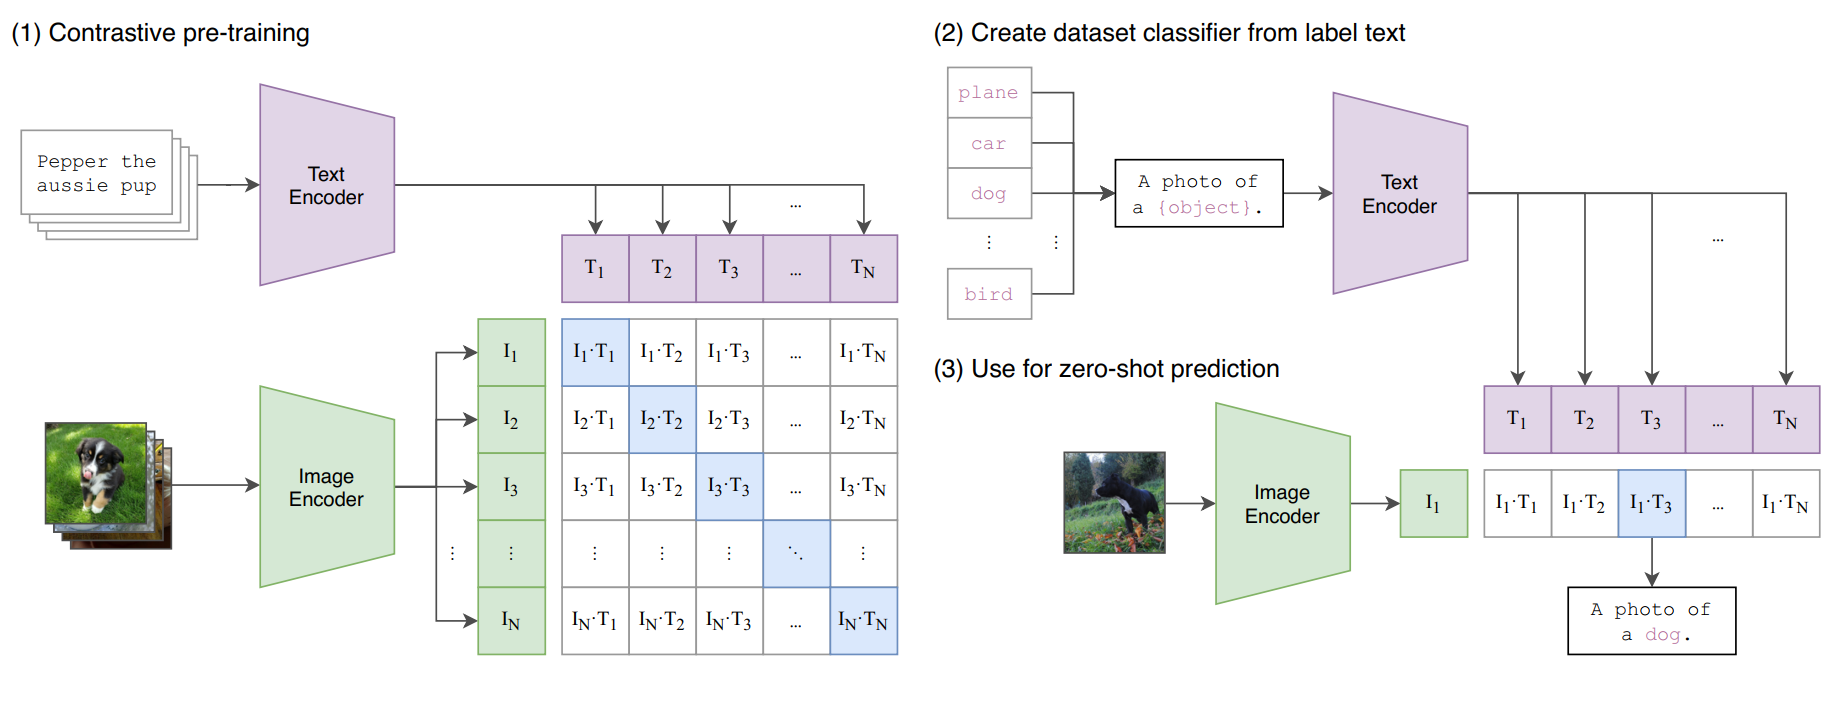

In [ ]:
#!conda install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 2.5 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-nm997pra
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-nm997pra
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=a8fd52a847f73f5ce5bc6fb35bf0ececb14cec370e16490bb0f49dc234cab2ab
  Stored in directory: /tmp/pip-ephem-wheel-cache-ccgypsn5/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


**Question 3: please perform a zeros-shot classification with CLIP on the image just bellow.** We consider that you can choose among three classes cat, dog or car.

In [ ]:
import clip

###########
#Exam will propably talk about clip
###########

device = "cuda" if torch.cuda.is_available() else "cpu"
model_clip, preprocess_clip = clip.load("ViT-B/32", device=device)
list_classes=["a car", "a dog", "a cat"]
#path_image = '/content/Cats_Dogs_Cars_Reduced/Dogs/White/9192.jpg'
PATH_data = '/content/drive/My Drive/Colab Notebooks/IA323/Cats_Dogs_Cars_Reduced'
path_image = PATH_data+'/Cars/Black/00052.jpg'

image = preprocess_clip(Image.open(path_image)).unsqueeze(0).to(device)

# write the rest of the code
text_input = clip.tokenize(list_classes).to(device)

with torch.no_grad():
  image_features = model_clip.encode_image(image)
  text_features = model_clip.encode_text(text_input)

  # Get the predicted class
  logits_image, logits_text = model_clip(image, text_input)
  label_probs = logits_image.softmax(dim=-1).cpu().numpy()
  predicted_class = list_classes[label_probs.argmax()]

print("Predicted class:", predicted_class)
print("Label probs:", label_probs, "([a car, a dog, a cat])")

100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 76.2MiB/s]


Predicted class: a car
Label probs: [[9.971e-01 2.115e-03 6.151e-04]] ([a car, a dog, a cat])


## 3 : CLIP zero shot

**Question 4: please perform a zeros show classification with CLIP on the test set.** What is your accuracy. What do you think about it.

In [ ]:
# Define the evaluation fct
def evaluate_zero_shot_clip(dataloader,model,text):
  model.eval()

  n_success = 0
  text = clip.tokenize(text).to(device)

  for data in tqdm(dataloader, desc='Evaluating'):

    with torch.no_grad() :
      image = data['input'].to(device)
      labels = data['label'].to(device)
      # write the rest
      image_features = model.encode_image(image)
      text_features = model.encode_text(text)

      image_features /= image_features.norm(dim=-1, keepdim=True)
      text_features /= text_features.norm(dim=-1, keepdim=True)

      similarity_scores = (100.0 * image_features @ text_features.T).softmax(dim=-1)

      # Get the predicted class
      id_infer = similarity_scores.argmax(dim=-1)
      id_infer = id_infer.cpu().numpy()

    # Check if prediction is correct
    n_success += sum(id_infer==labels.cpu().numpy())

  return n_success/(len(dataloader)*dataloader.batch_size)


In [ ]:


text = ["a dog", "a cat", "a car"]

accuracy = evaluate_zero_shot_clip(dataloader_test,model_clip,text)

print("\nAccuracy =", accuracy)

# With an accuracy of approximately 92%, we can conclude that CLIP performed well in a zeros-shot classification on the test set.


Evaluating: 100%|██████████| 11/11 [00:07<00:00,  1.44it/s]


Accuracy = 0.9275568181818182


With an accuracy of approximately 92%, we can conclude that CLIP performed well in a zeros-shot classification on the test set.

## 4 : Classification with CLIP + linear probing

Linear probing is commonly employed to evaluate the effectiveness of deep representations once the neural network has undergone sufficient training. This involves training an additional linear classifier on top of the pre-trained features. The parameters of the linear probe are initialized randomly, and the original classifier layer is disregarded. Importantly, the pre-trained backbone remains frozen and undergoes no further training during the linear probing phase.

In [ ]:
# Dataset clip_embed
# this function should help you to extract the CLIP embedding
def extract_feature( model, dataloader):
    model.eval()

    batch_idx =0
    with torch.no_grad():
        for data in tqdm(dataloader, desc='Extracting'):
            image = data['input'].to(device)
            labels = data['label'].to(device)
            outputs  = model_clip.encode_image(image).squeeze(0)

            if batch_idx ==0:
              output_concat = outputs.detach().clone()
              target_concat = labels.clone()


            else:
              output_concat=torch.cat((output_concat, outputs.detach()), 0)
              target_concat=torch.cat((target_concat, labels), 0)
            batch_idx+=1


    return  output_concat,target_concat


In [ ]:
class Dataset_from_tensor(torch.utils.data.Dataset):

    def __init__(self, data_feature, data_target,phase='label'):
        self.data_feature = data_feature
        self.data_target = data_target
        self.phase=phase

    def __len__(self):
        return len(self.data_feature)

    def __getitem__(self, index):
        # load data as tensor type (Height * Width * Channels)
        if self.phase=='label':
            data_feature = self.data_feature[index].float()
            data_target =  self.data_target[index]
            return {'input':data_feature,'label':data_target}

        else:
            data_feature = self.data_feature[index].float()
            return {'input':data_feature}

Clip_embeding_train,target_train= extract_feature(model_clip,dataloader_train)
Clip_embeding_val,target_val= extract_feature(model_clip, dataloader_val)
Clip_embeding_test,target_test= extract_feature(model_clip, dataloader_test)

dataloader_embed_train = torch.utils.data.DataLoader(Dataset_from_tensor(Clip_embeding_train,target_train),shuffle=True,batch_size=64)
dataloader_embed_val = torch.utils.data.DataLoader(Dataset_from_tensor(Clip_embeding_val,target_val),shuffle=True,batch_size=64)
dataloader_embed_test = torch.utils.data.DataLoader(Dataset_from_tensor(Clip_embeding_test,target_test),shuffle=False,batch_size=64)

Extracting: 100%|██████████| 11/11 [00:10<00:00,  1.09it/s]


**Question 5: please perform a linear probing classification with CLIP.**  You need to write the DNN and you need to train it. What is your accuracy. What do you think about it.

In [ ]:
# Define the model and the optimizer
class linear_probe_img_embed(nn.Module):
  def __init__(self,device, output_dim,model_CLIP="ViT-B/32"):
    super().__init__()

    # Linear layer on top of CLIP embeddings
    self.linear = nn.Linear(512, output_dim)  # CLIP embeddings are 512-dimensional


  def forward(self, embed):
    # Forward pass through the linear layer
    output = self.linear(embed)
    return output


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

List_classes = ['Dogs','Cats','Cars']
model_CLIP = 'ViT-B/32'

model = linear_probe_img_embed(device,len(List_classes),model_CLIP)
model.to(device)


# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 10  # Set your desired number of epochs

for epoch in range(num_epochs):
    train_loss, train_acc = train_model(model,dataloader_embed_train, criterion, optimizer,device)
    val_loss, val_acc = evaluate_model(model, dataloader_embed_val, criterion,device)
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")

# Test the trained model
test_loss, test_acc = evaluate_model(model, dataloader_embed_test, criterion,device)
print(f"Test Loss: {test_loss:.4f} - Test Acc: {test_acc:.2f}%")

Evaluating: 100%|██████████| 11/11 [00:00<00:00, 184.76it/s]


Epoch [1/10] - Train Loss: 0.9675 - Train Acc: 51.28% - Val Loss: 0.8966 - Val Acc: 67.38%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 506.36it/s]


Epoch [2/10] - Train Loss: 0.8300 - Train Acc: 81.08% - Val Loss: 0.7758 - Val Acc: 88.92%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 636.90it/s]


Epoch [3/10] - Train Loss: 0.7141 - Train Acc: 95.18% - Val Loss: 0.6753 - Val Acc: 96.00%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 412.67it/s]


Epoch [4/10] - Train Loss: 0.6181 - Train Acc: 98.72% - Val Loss: 0.5861 - Val Acc: 97.54%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 636.00it/s]


Epoch [5/10] - Train Loss: 0.5364 - Train Acc: 99.28% - Val Loss: 0.5118 - Val Acc: 98.77%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 657.85it/s]


Epoch [6/10] - Train Loss: 0.4694 - Train Acc: 99.28% - Val Loss: 0.4525 - Val Acc: 98.92%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 313.50it/s]


Epoch [7/10] - Train Loss: 0.4131 - Train Acc: 99.38% - Val Loss: 0.3981 - Val Acc: 98.92%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 184.20it/s]


Epoch [8/10] - Train Loss: 0.3659 - Train Acc: 99.44% - Val Loss: 0.3597 - Val Acc: 99.08%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 657.02it/s]


Epoch [9/10] - Train Loss: 0.3263 - Train Acc: 99.44% - Val Loss: 0.3194 - Val Acc: 99.08%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 637.31it/s]


Epoch [10/10] - Train Loss: 0.2933 - Train Acc: 99.49% - Val Loss: 0.2902 - Val Acc: 99.08%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 626.62it/s]

Test Loss: 0.2748 - Test Acc: 99.39%


In the context of linear probing, this accuracy represents the precision of the embeddings learned by CLIP. The accuracy obtained was approximately 99%. This high accuracy shows that CLIP was able to learn the rich semantic information of the images (embeddings). In this way, the linear probe was able to correctly classify most of the images in the test set with these embeddings.

## 5 : CLIP concept bottleneck model (CLIP-CBM)


Concept Bottleneck Models are a class of neural network architectures designed to capture and emphasize essential features or concepts within input data. In these models, a bottleneck layer is strategically placed within the network architecture, acting as a compression point that forces the network to distill and retain critical information while discarding less relevant details. The concept bottleneck serves as a conduit for information flow, ensuring that only the most discriminative features relevant to the task at hand pass through. By focusing on the extraction and representation of key concepts, these models aim to enhance interpretability, reduce overfitting, and promote generalization. Concept Bottleneck Models find applications in various domains, including computer vision and natural language processing, where the identification and utilization of high-level concepts are crucial for robust and effective learning.

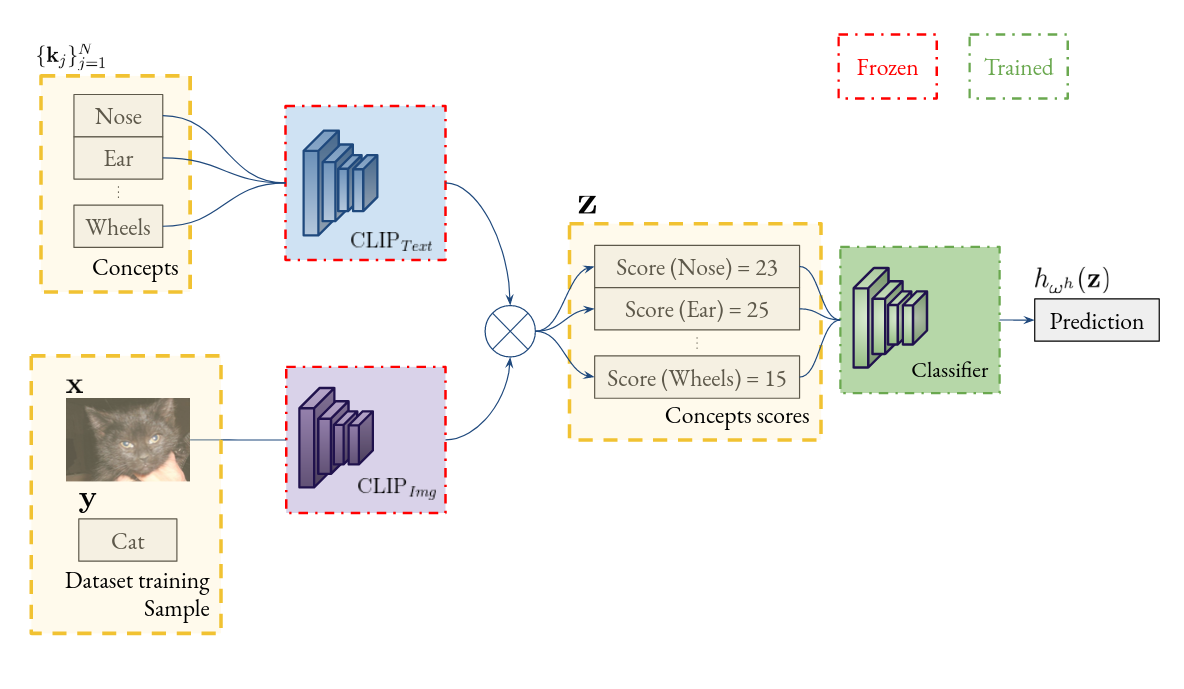

**question6 based on the figure above we want that you extract the a latent space that measure the similarity between the image and a set of concept. Then please write and train a concept bottleneck model.** You need to define the good set of concepts. Analyse your performences with different set of concepts. Compare to your results in question 4.

In [ ]:
from io import TextIOBase

# Dataset z

# List_concepts=['Black','White','License plate', 'Four-wheeled', 'Headlights']
# List_concepts=['Black','White','Whiskered', 'Snout', 'Headlights']#,'a cat', 'a dog', 'a car'
List_concepts=['Furry', 'Whiskered', 'Pointy-eared', 'Slitted-eyed',
               'Four-legged', 'Metallic', 'Four-wheeled', 'Headlights',
               'Windshield', 'License plate', 'Snout', 'Wagging-tailed',
               'Snout-nosed', 'Floppy-eared', 'Tail-wagging']

# you need to write clever concepts
text_featuresconcepts = clip.tokenize(List_concepts).to(device)
text_featuresconcepts = model_clip.encode_text(text_featuresconcepts)

# Define the model and the optimizer
class CBM_Net(nn.Module):
  def __init__(self,device, output_dim,text_featuresconcepts):
    super().__init__()
    self.device = device
    self.text_featuresconcepts = text_featuresconcepts.to(torch.float32)
    self.linear = nn.Linear(text_featuresconcepts.size(0), output_dim)
    self.features = None

  def forward(self, embed): #model.eval()
    # Calculate the similarity between the image and concepts
    similarity_scores = ((embed @ self.text_featuresconcepts.T)).softmax(dim=-1) #64x5
    self.features = similarity_scores.clone().detach()

    # Pass the similarity through a linear layer
    logits = self.linear(similarity_scores)
    return logits

  def get_features(self):
    return self.features

  def get_classifier_head(self):
    return self.linear

In [ ]:
model_unbiaised = CBM_Net(device,len(List_classes),text_featuresconcepts)
model_unbiaised.to(device)

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_unbiaised.parameters(), lr=0.2)
num_epochs = 10  # Set your desired number of epochs

for epoch in range(num_epochs):
    train_loss, train_acc = train_model(model_unbiaised,dataloader_embed_train, criterion, optimizer,device)
    val_loss, val_acc = evaluate_model(model_unbiaised, dataloader_embed_val, criterion,device)
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")

# Test the trained model
test_loss, test_acc = evaluate_model(model_unbiaised, dataloader_embed_test, criterion,device)
print(f"Test Loss: {test_loss:.4f} - Test Acc: {test_acc:.2f}%")

Evaluating: 100%|██████████| 11/11 [00:00<00:00, 165.70it/s]


Epoch [1/10] - Train Loss: 0.2940 - Train Acc: 91.85% - Val Loss: 0.1632 - Val Acc: 94.46%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 303.50it/s]


Epoch [2/10] - Train Loss: 0.1192 - Train Acc: 96.36% - Val Loss: 0.1449 - Val Acc: 94.62%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 523.92it/s]


Epoch [3/10] - Train Loss: 0.1049 - Train Acc: 96.67% - Val Loss: 0.1453 - Val Acc: 95.54%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 489.47it/s]


Epoch [4/10] - Train Loss: 0.0991 - Train Acc: 96.82% - Val Loss: 0.1365 - Val Acc: 96.46%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 497.62it/s]


Epoch [5/10] - Train Loss: 0.0940 - Train Acc: 97.33% - Val Loss: 0.1356 - Val Acc: 95.69%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 482.62it/s]


Epoch [6/10] - Train Loss: 0.0927 - Train Acc: 97.28% - Val Loss: 0.1412 - Val Acc: 95.69%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 419.04it/s]


Epoch [7/10] - Train Loss: 0.0960 - Train Acc: 97.28% - Val Loss: 0.2576 - Val Acc: 95.69%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 502.32it/s]


Epoch [8/10] - Train Loss: 0.0874 - Train Acc: 97.54% - Val Loss: 0.1245 - Val Acc: 96.62%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 496.19it/s]


Epoch [9/10] - Train Loss: 0.0866 - Train Acc: 97.38% - Val Loss: 0.1315 - Val Acc: 96.62%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 470.98it/s]


Epoch [10/10] - Train Loss: 0.0794 - Train Acc: 97.59% - Val Loss: 0.1243 - Val Acc: 96.92%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 462.16it/s]

Test Loss: 0.0922 - Test Acc: 96.95%


By varying the set of concepts, we can have some conclusions. If the set is only made up of concepts from one of the classes (dog or cat or car), the model is not well trained and the accuracy obtained is worse. If, for example, we only use car concepts, we get an accuracy of around 80%. However, if the set of concepts is made up of concepts from several classes, the model is better trained, obtaining a very high accuracy. For example, by assembling a set with two concepts from each class, we obtain a considerable accuracy of approximately 99%.
Therefore, in order to train the model satisfactorily and obtain good accuracy, it is important to provide a large set of concepts, containing plenty of concepts from all the classes. By using a set of 15 concepts, we get a good accuracy of 96%.

Compared to the performance of the zero shot classification with CLIP, which obtained an accuracy of 92%, we conclude that this CLIP-CBM model has indeed improved classification performance. One of the reasons is that CLIP-CBM takes advantage of both CLIP's ability to learn the rich semantic information of the images (embeddings) and the linear classifier's good classification ability.

**question7: normaly on the previous question you have trained with non biaised a dataset. Please add biaised with the color. For exemple all the object of one class have a color and retrain.** Analyse the results and explain it. Why did we do this experiment.

When using a dataset in which one of the classes contains only one color, the model will consider color as a determining concept in the classification of that class. In this way, biased train datasets can lead to biased model predictions. For example, if all the cars in the train set are white, the model will only be able to classify white cars. Thus, when testing the model with a test set containing cars of different colors, the model will have difficulty to classify the cars, since it always associated the car with the color white during training. Therefore, its performance will be lower and, consequently, its accuracy worse than that obtained in the non-biaised dataset.

**question8: please show the statistic of each concept on the latent space of for one class using a CBM** Analyse the results and explain it.




In [ ]:
## Train with the non biaised dataset

Clip_embeding_train,target_train= extract_feature(model_clip,dataloader_train)
Clip_embeding_val,target_val= extract_feature(model_clip, dataloader_val)
Clip_embeding_test,target_test= extract_feature(model_clip, dataloader_test)

dataloader_embed_train = torch.utils.data.DataLoader(Dataset_from_tensor(Clip_embeding_train,target_train),shuffle=True,batch_size=64)
dataloader_embed_val = torch.utils.data.DataLoader(Dataset_from_tensor(Clip_embeding_val,target_val),shuffle=True,batch_size=64)
dataloader_embed_test = torch.utils.data.DataLoader(Dataset_from_tensor(Clip_embeding_test,target_test),shuffle=False,batch_size=64)

Extracting: 100%|██████████| 11/11 [00:08<00:00,  1.30it/s]


In [ ]:
!pip install seaborn

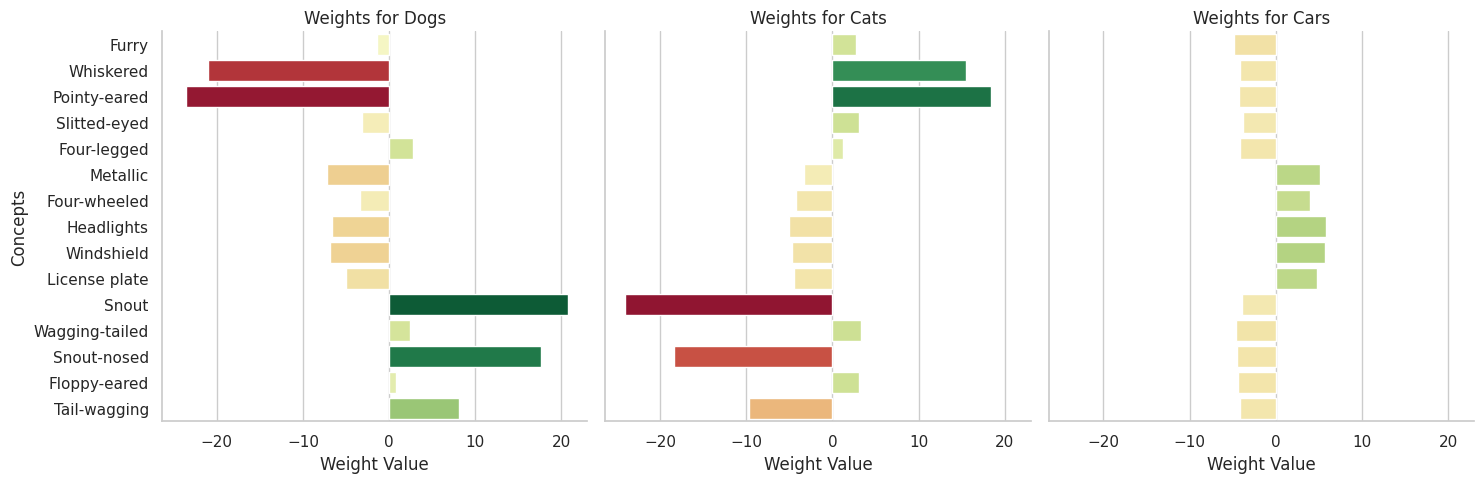

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a DataFrame for all classes
df_all = pd.DataFrame()

# Iterate over classes
for class_index, class_name in enumerate(List_classes):
    # Extract the weights corresponding to the specified class and first 5 concepts
    weights_for_class = model_unbiaised.linear.weight[class_index, :].detach().cpu().numpy()

    # Create a DataFrame for plotting
    df = pd.DataFrame({'Concepts': List_concepts, 'Weights': weights_for_class, 'Class': class_name})

    # Append the DataFrame for the current class to the overall DataFrame
    df_all = pd.concat([df_all, df])

# Set seaborn style
sns.set(style="whitegrid")

# Plot the weights with colored bars (horizontal) using catplot
g = sns.catplot(x='Weights', y='Concepts', hue='Weights', col='Class',
                data=df_all, palette='RdYlGn', kind='bar',
                col_wrap=len(List_classes), height=5, aspect=1, legend=False)

# Adjust labels and titles
g.set_axis_labels('Weight Value', 'Concepts')
g.set_titles('Weights for {col_name}')

# Display the plot
plt.show()

When analyzing the statistic of each concept on the latent space for each class, we see that the concepts that are actually characteristic of each class have a very high weight, while the concepts that don't represent the class have a very negative weight. For example, for the dog, the model has a very high weight for Snout and Snout-nosed, which are very characteristic dog concepts, while it has a very negative weight for Whiskered, a more characteristic cat concept. So much so that the weight of Whiskered is high for the cat class. For the car class, in turn, concepts more characteristic of cars, such as Four-Wheeled, Metallic and Headlights, have the most positive weights.

Therefore, we can conclude that the model is indeed well trained to classify the classes dog, cat and car.

## 6 : Méthodes d'explications Post-Hoc (LIME et SHAP)

**question9: please try to see  what explain could LIME provide if associate with the CBM** Could you do it without the CBM?

Have a look at this repo for LIME :   https://github.com/marcotcr/lime


**LIME (Local Intepretable Mode-agnostic Explanations)**

- Explaining black box model (Complex model)
- Zoom into the local area of the individual prediction
- Lime simply fits a linear interpretable model in that local area (Make a surrogate model: simple model around the complex one).
- The only requirement is that the explanations are locally faithful but they might not make sense globally.

**LIME with CBM**

As LIME may represent locally the adaptation of the network, we may use it to explain each feature when associated with the CBM and therefore provide finer explanations to our models. This is even better because humans can understand the sense of the concepts in the CBM and therefore verify manually if the network learns what it should.

**LIME without CBM**

Yes we could use LIME without CBM. LIME can help identify regions that are important for overall network classification (kind like GradCam), but why these regions are important remains a mystery and to solve this mistery we use CBM.

In [ ]:
!pip install lime
!pip install shap


In [ ]:
import os
import matplotlib.pyplot as plt
from torchvision import models, transforms
from PIL import Image

(-0.5, 609.5, 403.5, -0.5)

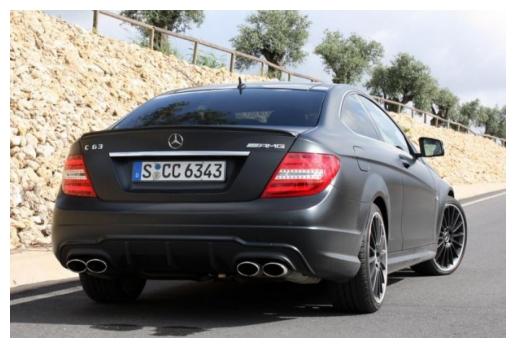

In [ ]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

#img = get_image('Cats_Dogs_Cars_Reduced/Cats/Black/12340.jpg')
img = get_image('Cats_Dogs_Cars_Reduced/Cars/Black/01564.jpg')
plt.imshow(img)
plt.axis('off')

We need to convert this image to Pytorch tensor and also apply whitening as used by our pretrained model.

In [ ]:
#!pip install ftfy regex tqdm
#!pip install git+https://github.com/openai/CLIP.git

import clip

model, preprocess = clip.load("ViT-B/32")

image = preprocess(img).unsqueeze(0)
#classif_list = ['Dogs','Cats','Cars']
#classif_list = ['Whiskered', 'Pointy-eared', 'Slitted-eyed', 'Four-legged', 'Metallic']
classif_list = ['Furry', 'Whiskered', 'Pointy-eared', 'Slitted-eyed',
               'Four-legged', 'Metallic', 'Four-wheeled', 'Headlights',
               'Windshield', 'License plate', 'Snout', 'Wagging-tailed',
               'Snout-nosed', 'Floppy-eared', 'Tail-wagging']
text = clip.tokenize(classif_list)
#text = clip.tokenize()


Get the predicition for our image

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image = image.to(device)
text = text.to(device)
model = model.to(device)
image_features = model.encode_image(image)
text_features = model.encode_text(text)

logits_per_image, logits_per_text = model(image, text)


Predicitions we got are logits (Logits are the raw output values from the last layer of the neural network before applying the softmax activation function). Let's pass that through softmax to get probabilities and class labels for top 5 predictions.

In [ ]:
import torch.nn.functional as F
#probs = logits_per_image.softmax(dim=-1).cpu().numpy()
probs = F.softmax(logits_per_image, dim=1)
probs5 = probs.topk(15)
probs_numpy = probs5[0][0].cpu().detach().numpy()
indices_numpy = probs5[1][0].cpu().detach().numpy()

# Now iterate over the results
for p, c in zip(probs_numpy, indices_numpy):
  tuple((p,c, text[c]))
  print(p,classif_list[c])

0.51 License plate
0.4292 Four-wheeled
0.01639 Metallic
0.00963 Four-legged
0.00934 Tail-wagging
0.007618 Headlights
0.006725 Windshield
0.003832 Wagging-tailed
0.003489 Whiskered
0.001926 Slitted-eyed
0.001168 Snout
0.000535 Snout-nosed
0.0003145 Furry
0.0001878 Pointy-eared
3e-06 Floppy-eared


We are getting ready to use Lime. Lime produces the array of images from original input image by pertubation algorithm. So we need to provide two things: (1) original image as numpy array (2) classification function that would take array of purturbed images as input and produce the probabilities for each class for each image as output.

For Pytorch, first we need to define two separate transforms: (1) to take PIL image, resize and crop it (2) take resized, cropped image and apply whitening.

In [ ]:
def get_pil_transform():
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    return transf

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

Now we are ready to define classification function that Lime needs. The input to this function is numpy array of images where each image is ndarray of shape (channel, height, width). The output is numpy aaray of shape (image index, classes) where each value in array should be probability for that image, class combination.

In [ ]:
def batch_predict(images):
    model.eval()
    #batch = torch.stack(tuple(preprocess(i) for i in images), dim=0)
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)

    #logits_per_image = model(batch)
    logits_per_image, logits_per_text = model(batch, text)
    probs = F.softmax(logits_per_image, dim=1)
    return probs.detach().cpu().numpy()

  0%|          | 0/1000 [00:00<?, ?it/s]

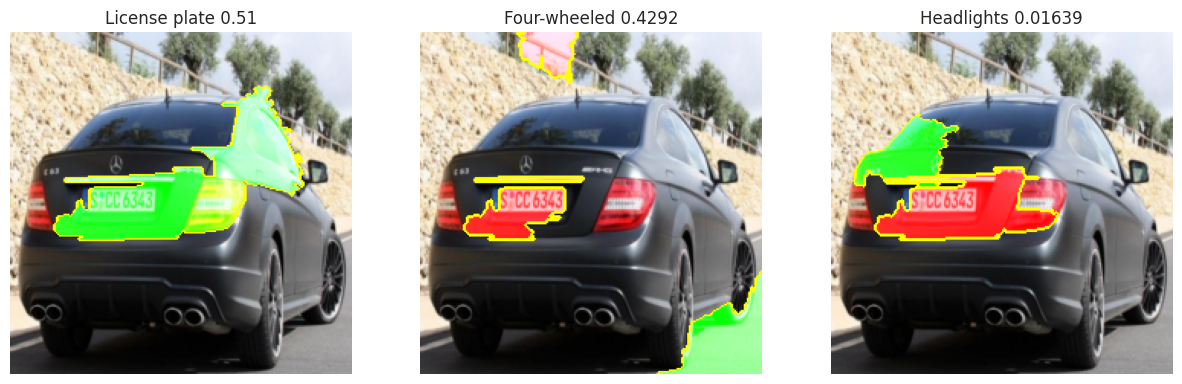

In [ ]:
import numpy as np
# Let's test our function for the sample image.
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()

from lime import lime_image

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)),
                                         batch_predict, # classification function
                                         top_labels=3,
                                         hide_color=0,
                                         num_samples=1000) # number of images that will be sent to classification function

# Let's use mask on image and see the areas that are encouraging the top prediction.
from skimage.segmentation import mark_boundaries

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=3, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
ax1.imshow(img_boundry1)
ax1.set_title(str(classif_list[explanation.top_labels[0]])+' '+str(probs_numpy[0]))
ax1.axis('off')

temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=False, num_features=3, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
ax2.imshow(img_boundry2)
ax2.set_title(str(classif_list[explanation.top_labels[1]])+' '+str(probs_numpy[1]))
ax2.axis('off')

temp, mask = explanation.get_image_and_mask(explanation.top_labels[2], positive_only=False, num_features=3, hide_rest=False)
img_boundry3 = mark_boundaries(temp/255.0, mask)
ax3.imshow(img_boundry3)
ax3.set_title(str(classif_list[explanation.top_labels[2]])+' '+str(probs_numpy[2]))
ax3.axis('off')

plt.show()

As we can see in the pictures above, the top 3 concepts identified were License plate, Four-wheeled and Headlights. In the first image, we can see that LIME was able to identify the license plate region well (green zone). In the second image, LIME has well identified the four-wheeled region (green zone) and also the region that does not represent the four-wheeled concept, which actually represents the license plate (red region). In the third image, as the weight associated with Headlights was low, LIME was unable to identify the region in which this concept is found, identifying only the region that does not represent Headlights (red rone).

Therefore, we can conclude that the implemented LIME was able to identify the regions of the concepts with the highest probability.

**question10: please try to see  what explain could SHAP provide if associate with the CBM** Could you do it without the CBM?

Have a look at this repo for shap :  https://github.com/shap/shap

*   SHAP associated with CBM:

> When associated with CBM, SHAP could provide explanations for the predictions made by the CBM. For example, SHAP could identify which concepts or features extracted by the CBM contributed the most to a specific prediction. This could help users understand how the CBM is making decisions and which aspects of the input data are most influential.

*   Without CBM:

> Even without using CBM, SHAP can still be applied to explain predictions made by any machine learning model, including traditional models like logistic regression or decision trees, or more complex models like deep neural networks. In this case, SHAP would provide explanations for individual predictions, highlighting the importance of each feature in contributing to the model's output for a given instance.

In [ ]:
# Define the model and the optimizer
class CBM_Net_shap(nn.Module):
  def __init__(self,device, output_dim,text_featuresconcepts):
    super().__init__()
    self.device = device
    self.text_featuresconcepts = text_featuresconcepts.to(torch.float32)
    self.linear = nn.Linear(text_featuresconcepts.size(0), output_dim)

  def forward(self, similarity_scores):
     # Pass the similarity through a linear layer
    logits = self.linear(similarity_scores)

    return logits

In [ ]:
## Train with the non biaised dataset

Clip_embeding_train,target_train= extract_feature(model_clip,dataloader_train)
Clip_embeding_val,target_val= extract_feature(model_clip, dataloader_val)
Clip_embeding_test,target_test= extract_feature(model_clip, dataloader_test)

Clip_embeding_train = ((Clip_embeding_train.to(torch.float32) @ text_featuresconcepts.T.to(torch.float32))).softmax(dim=-1)
Clip_embeding_val = ((Clip_embeding_val.to(torch.float32) @ text_featuresconcepts.T.to(torch.float32))).softmax(dim=-1)
Clip_embeding_test = ((Clip_embeding_test.to(torch.float32) @ text_featuresconcepts.T.to(torch.float32))).softmax(dim=-1)

dataloader_embed_train_15 = torch.utils.data.DataLoader(Dataset_from_tensor(Clip_embeding_train,target_train),shuffle=True,batch_size=1000)
dataloader_embed_val_15 = torch.utils.data.DataLoader(Dataset_from_tensor(Clip_embeding_val,target_val),shuffle=True,batch_size=1000)
dataloader_embed_test_15 = torch.utils.data.DataLoader(Dataset_from_tensor(Clip_embeding_test,target_test),shuffle=False,batch_size=1000)

Extracting: 100%|██████████| 11/11 [00:08<00:00,  1.26it/s]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

text_featuresconcepts = clip.tokenize(List_concepts).to(device)
text_featuresconcepts = model_clip.encode_text(text_featuresconcepts)
text_featuresconcepts = text_featuresconcepts.to(torch.float32)

model_shap = CBM_Net_shap(device,len(List_classes),text_featuresconcepts)
model_shap.to(device)

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_shap.parameters(), lr=0.2)
num_epochs = 10  # Set your desired number of epochs

for epoch in range(num_epochs):
    train_loss, train_acc = train_model(model_shap,dataloader_embed_train_15, criterion, optimizer,device)
    val_loss, val_acc = evaluate_model(model_shap, dataloader_embed_val_15, criterion,device)
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")

# Test the trained model
test_loss, test_acc = evaluate_model(model_shap, dataloader_embed_test_15, criterion,device)
print(f"Test Loss: {test_loss:.4f} - Test Acc: {test_acc:.2f}%")

Evaluating: 100%|██████████| 1/1 [00:00<00:00, 102.87it/s]


Epoch [1/10] - Train Loss: 1.0279 - Train Acc: 44.51% - Val Loss: 0.7666 - Val Acc: 92.31%


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 87.69it/s]


Epoch [2/10] - Train Loss: 0.7113 - Train Acc: 88.67% - Val Loss: 0.5630 - Val Acc: 86.31%


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 90.57it/s]


Epoch [3/10] - Train Loss: 0.5204 - Train Acc: 85.69% - Val Loss: 0.4098 - Val Acc: 91.54%


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 95.20it/s]


Epoch [4/10] - Train Loss: 0.3777 - Train Acc: 92.82% - Val Loss: 0.3190 - Val Acc: 93.38%


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 81.24it/s]


Epoch [5/10] - Train Loss: 0.2935 - Train Acc: 94.92% - Val Loss: 0.2709 - Val Acc: 94.00%


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 95.93it/s]


Epoch [6/10] - Train Loss: 0.2463 - Train Acc: 95.13% - Val Loss: 0.2373 - Val Acc: 94.00%


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 77.18it/s]


Epoch [7/10] - Train Loss: 0.2114 - Train Acc: 95.18% - Val Loss: 0.2148 - Val Acc: 93.69%


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 95.73it/s]


Epoch [8/10] - Train Loss: 0.1881 - Train Acc: 94.92% - Val Loss: 0.2023 - Val Acc: 93.38%


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 43.54it/s]


Epoch [9/10] - Train Loss: 0.1752 - Train Acc: 94.56% - Val Loss: 0.1943 - Val Acc: 93.38%


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 93.28it/s]


Epoch [10/10] - Train Loss: 0.1641 - Train Acc: 94.56% - Val Loss: 0.1878 - Val Acc: 93.69%


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 101.84it/s]

Test Loss: 0.1766 - Test Acc: 93.59%


In [ ]:
import shap
# first we need to define our input and output. Since we are working with CBM,
# the input is the scores given by clip to a given image, and the output is
# the classification

for data in tqdm(dataloader_embed_train_15):
  X_train = data['input'].to(device)
  break

for data in tqdm(dataloader_embed_test_15):
  X_test = data['input'].to(device)
  break

#Create SHAP explainer
explainer = shap.DeepExplainer(model_shap, X_train)

# use Kernel SHAP to explain test set predictions
shap_values = explainer.shap_values(X_test,check_additivity=False)
# black dog 10
# white cat 400
# white car 630

  0%|          | 0/1 [00:00<?, ?it/s]


1.   SHAP results for a **dog** image:



In [ ]:
# Result 1 - dog class

shap.initjs()
shap.plots.force(explainer.expected_value[0], shap_values[0][10,:], feature_names = List_concepts)

In [ ]:
# Result 2 - cat class

shap.initjs()
shap.plots.force(explainer.expected_value[1], shap_values[1][10,:], feature_names = List_concepts)

In [ ]:
# Result 3 - car class

shap.initjs()
shap.plots.force(explainer.expected_value[2], shap_values[2][10,:], feature_names = List_concepts)

As we can see in the images below, the results show that the shapley value score for the dog class (Result 1) was considerably positive, while the shapley value scores for the other classes (Results 2 and 3) were negative. In addition, SHAP also shows that concepts such as Four-legged contributed to classifying the image as a dog.

Therefore, SHAP was applied correctly, being able to explain how the model classified the dog image as actually being a dog.

2.   SHAP results for a **cat** image:



In [ ]:
# Result 1 - dog class

shap.initjs()
shap.plots.force(explainer.expected_value[0], shap_values[0][400,:], feature_names = List_concepts)

In [ ]:
# Result 2 - cat class

shap.initjs()
shap.plots.force(explainer.expected_value[1], shap_values[1][400,:], feature_names = List_concepts)

In [ ]:
# Result 3 - car class

shap.initjs()
shap.plots.force(explainer.expected_value[2], shap_values[2][400,:], feature_names = List_concepts)

As we can see in the images below, the results show that the shapley value score for the cat class (Result 2) was considerably positive, while the shapley value scores for the other classes (Results 1 and 3) were negative. In addition, SHAP also shows that concepts such as Furry contributed to classifying the image as a cat.

Therefore, SHAP was applied correctly, being able to explain how the model classified the cat image as actually being a cat.

3.   SHAP results for a **car** image:


In [ ]:
# Result 1 - dog class

shap.initjs()
shap.plots.force(explainer.expected_value[0], shap_values[0][630,:], feature_names = List_concepts)

In [ ]:
# Result 2 - cat class

shap.initjs()
shap.plots.force(explainer.expected_value[1], shap_values[1][630,:], feature_names = List_concepts)

In [ ]:
# Result 3 - car class

shap.initjs()
shap.plots.force(explainer.expected_value[2], shap_values[2][630,:], feature_names = List_concepts)

As we can see in the images below, the results show that the shapley value score for the car class (Result 3) was considerably positive, while the shapley value scores for the other classes (Results 1 and 2) were negative. In addition, SHAP also shows that concepts such as Four-wheeled contributed to classifying the image as a car.

Therefore, SHAP was applied correctly, being able to explain how the model classified the car image as actually being a car.

## 7 : Counterfactual (Au niveau de z)

**question11: please perform a counterfactual explanation.**

Counterfactual explanations (CFEs) are an emerging technique of local explainability. They explain a prediction by calculating a change (usually minimal) in a datapoint that would cause the underlying ML model to classify it in a desired class. Unlike other explainability methods, CFEs aim to provide a precise and actionable recommendation to achieve a desired outcome. In other words, it provides "what-if" explanations for model output.

We will rely on [visual-counterfactuals](https://github.com/facebookresearch/visual-counterfactuals/tree/main) github that provides an implementation of the method to compute semantically consistent visual counterfactuals.
Paper : [Making Heads or Tails: Towards Semantically
 Consistent Visual Counterfactuals](https://arxiv.org/pdf/2203.12892.pdf)

 This method relies on the confusion matrix to obtain the classes with which the images are most frequently confused.

 In addition to this method, we could also implement a program that extracts the average measures of each feature where the images are well classified and then increase or decrease the features of the misclassified images to classify them well. Where finally, it is obtained which characteristic needed more or less weight in the classification.

In [ ]:
!pip install torchmetrics
import torchmetrics

from sklearn.metrics import confusion_matrix

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 8.1 MB/s eta 0:00:00


In [ ]:
@torch.no_grad()
def process_dataset(model, dataloader, device):
    """
    Process a dataset using a pre-trained classification model.
    We return the spatial feature representations, the predictions,
    the targets, top-1 accuracy and a confusion matrix as a dictionary.
    """
    top1 = torchmetrics.Accuracy(task='multiclass',num_classes=3,top_k=1)

    top1.to(device)
    model.to(device)

    model.eval()

    features = []
    preds = []
    targets = []

    for data in tqdm(dataloader, desc='Evaluating'):

        images = data['input'].to(device)
        target = data['label'].to(device)
        output = model(images)
        _, predict = output.max(1)
        top1(output, target)
        similarity_scores = model.get_features()

        features.append(similarity_scores.cpu())
        targets.append(target.cpu())
        preds.append(predict.cpu())

    features = torch.cat(features, dim=0)
    preds = torch.cat(preds, dim=0)
    targets = torch.cat(targets, dim=0)

    confusion_mat = confusion_matrix(targets.numpy(), preds.numpy())

    result = {
        "features": features,
        "preds": preds,
        "targets": targets,
        "top1": top1.compute(),
        "confusion_matrix": confusion_mat,
    }

    return result

In [ ]:
def get_query_distractor_pairs(
    dataset,
    confusion_matrix,
    max_num_distractors,
    seed=0,
):
    """
    Compute query-distractor image pairs using a confusion matrix:
        (1) For each query class, we select the most confusing
        class as it's distractor class.
        (2) Next, we randomly sample `max_num_distractors`
        from the distractor class as the distractor images.

    We return the result as a a dictionary.
    """
    np.random.seed(seed)
    result = {}

    # process all images
    for query_index in range(len(dataset)):
        # determine the distractor class for this sample
        query_class = dataset.__getitem__(query_index)["label"]
        row = np.copy(confusion_matrix[query_class])
        row[query_class] = -1
        if np.all(row <= 0):  # no signal from confusion matrix - skip
            continue
        distractor_class = np.argmax(row)
        # gater all images belonging to distractor class
        distractor_index = dataset.get_target(distractor_class)

        # randomly select `max_num_distractors`
        num_random = min(len(distractor_index), max_num_distractors)
        distractor_index = np.random.choice(distractor_index, num_random, replace=False)
        distractor_index = distractor_index.reshape(-1).tolist()

        # add to dictionary
        result[query_index] = {
            "distractor_index": distractor_index,
            "distractor_class": distractor_class,
            "query_index": query_index,
            "query_class": query_class,
        }

    return result


In [ ]:
def _find_knn_cells(query_aux_features, distractor_aux_features, all_edits, topk):
    """
    Find top-K most semantically similar cells using auxiliary feature
    representations.
    """
    assert len(query_aux_features.shape) == 2
    assert len(distractor_aux_features.shape) == 2

    query_aux_features = F.normalize(
        query_aux_features, dim=1, p=2
    )  # n_pixels x dim_aux
    distractor_aux_features = F.normalize(
        distractor_aux_features, dim=1, p=2
    )  # n_pixels x dim_aux

    logits = torch.matmul(query_aux_features, distractor_aux_features.t())
    logits = torch.FloatTensor([logits[edit] for edit in all_edits])
    numel = int(torch.numel(logits) * topk)
    knn = torch.topk(logits, k=numel, largest=True)[1].tolist()

    return [all_edits[ii] for ii in knn]

@torch.no_grad()
def _find_single_best_edit(
    all_combinations,
    all_edits,
    distractor_class,
    classification_head,
    query_aux_features,
    distractor_aux_features,
    lambd,
    dims,
    temperature,
):
    """
    Find next single best edit.

    args:
        all_combinations: all combinations of query and distractor features
            when applying different single edits.
        all_edits: all edits of query and distractor cells
        distractor_class: the distractor class index
        classification_head: the classification head
        query_aux_features: auxiliary features query
        distractor_aux_features: auxiliary features distractor
        lambd: weight to balance the losses
        dims: features_dim, n_pix, n_pixels
        temperature: softmax temperature

    return:
        edit_query, edit_distractor: single best edit based on loss objective
        from the paper (Equation 4).

        argmax class_objective(edit) + lambd * semantic_objective(edit)
    """
    # compute classification loss via classifier head
    classification_head.eval()
    n_feat, n_pix, _ = dims
    logits_class = classification_head(all_combinations.t()
        .contiguous()
        .view(-1, n_pix)
        .cuda()
    )
    probs_class = F.softmax(logits_class, dim=1)[:, distractor_class]
    optim_class = probs_class.cpu().numpy()
    optim_class = np.log(optim_class)

    optim_total = optim_class

    # find best edit
    best_edit = np.argmax(optim_total)
    return all_edits[best_edit][0], all_edits[best_edit][1]

def _get_feature_representations_of_all_edits(query_fl, distractor_fl, all_edits):
    """
    Construct feature representations when performing different edits.
    """
    num_allowed = len(all_edits)
    features_all_edits = torch.clone(query_fl).repeat(num_allowed,1)

    for ii in range(num_allowed):
        cell_I, cell_I_prime = all_edits[ii]
        features_all_edits[cell_I].copy_(distractor_fl[cell_I_prime][0])
    return features_all_edits

def compute_counterfactual(
    query,
    distractor,
    classification_head,
    distractor_class,
    query_aux_features,
    distractor_aux_features,
    lambd,
    temperature,
    topk,
):
    """
    args:
        query: query feature repr (dim x n_pix x n_pix)
        distractor: distractor feature repr (N x dim x n_pix x n_pix)
        classification_head: classification head
        distractor_class: distractor class
        query_aux_features: query auxiliary feature repr (dim_aux x n_pix x n_pix)
        distractor_aux_features: distractor auxiliary feature repr
            (N x dim_aux x n_pix x n_pix)
        lambd: lambda loss balancing weight
        topk: only use top-k most similar cells

    return:
        edits: list of edits that flip model's prediction
    """
    # eval
    classification_head.eval()

    #query = torch.reshape(query, (15,1))
    # get dimensions of spatial feature representations
    n_feat, n_pix = query.shape[0], query.shape[1]
    n_pixels = n_pix * n_pix

    # flatten
    query_fl = query.reshape(n_feat, -1).t().cuda()  # n_pixels x dim
    distractor_fl = distractor.reshape(-1, n_feat).cuda()
    #(
    #    torch.permute(distractor, (0, 2, 3, 1)).reshape(-1, n_feat).cuda()
    #)  # N * n_pixels x dim

    query_aux_features_fl, distractor_aux_features_fl = None, None

    # determine all possible edits
    query_edits = (
        np.arange(query_fl.shape[0] * distractor_fl.shape[0]) // distractor_fl.shape[0]
    )
    distractor_edits = (
        np.arange(query_fl.shape[0] * distractor_fl.shape[0]) % distractor_fl.shape[0]
    )
    all_edits = [(i, j) for i, j in zip(query_edits, distractor_edits)] #posibles combinaciones

    if topk is not None:
        all_edits = _find_knn_cells(
            query_aux_features_fl, distractor_aux_features_fl, all_edits, topk
        )

    # init variables
    current = query_fl.clone()
    list_of_edits = []
    all_combinations = _get_feature_representations_of_all_edits(
        query_fl, distractor_fl, all_edits
    )

    # loop until prediction changes
    while (
        torch.argmax(
            classification_head(current.t().contiguous().view(n_pix))
        )
        != distractor_class
    ):
        # find next best cell replacement
        query_cell, distractor_cell = _find_single_best_edit(
            all_combinations,
            all_edits,
            distractor_class,
            classification_head,
            query_aux_features_fl,
            distractor_aux_features_fl,
            lambd=lambd,
            dims=(n_feat, n_pix, n_pixels),
            temperature=temperature,
        )

        # update variables
        list_of_edits.append((query_cell, distractor_cell))
        current[query_cell].copy_(distractor_fl[distractor_cell])
        all_edits = [
            (i, j)
            for i, j in all_edits
            if i != query_cell and j != distractor_cell  # noqa
        ]
        all_combinations = _get_feature_representations_of_all_edits(
            current, distractor_fl, all_edits
        )

    return list_of_edits


In [ ]:
assert torch.cuda.is_available()
device = torch.device("cuda")

dataset = Dataset_from_tensor(Clip_embeding_train,target_train) #Cats_Dogs_dataset_x_test

# process dataset
print("Pre-compute classifier predictions")
result = process_dataset(model_unbiaised, dataloader_embed_test, device)
features = result["features"]
preds = result["preds"].numpy()
targets = result["targets"].numpy()
print("Top-1 accuracy: {:.2f}".format(100 * result["top1"]))

query_distractor_pairs = torch.load('/content/drive/My Drive/Colab Notebooks/IA323/CVE/query_distractor_pairs')

# get classifier head
classifier_head = model_unbiaised.get_classifier_head()
classifier_head = torch.nn.DataParallel(classifier_head.cuda())
classifier_head.eval()

use_auxiliary_features = False

# compute counterfactuals
print("Compute counterfactuals")
counterfactuals = {}

for query_index in tqdm(range(len(dataset))):

    if query_index not in query_distractor_pairs.keys():
        continue  # skips images that were classified incorrectly

    # gather query features

    query = features[query_index]  # dim x n_row x n_row
    query = query.unsqueeze(0)
    query_pred = preds[query_index]
    if query_pred != targets[query_index]:
        continue  # skip if query classified incorrect

    # gather distractor features
    distractor_target = query_distractor_pairs[query_index][
        "distractor_class"
    ]  # noqa
    distractor_index = query_distractor_pairs[query_index][
        "distractor_index"
    ]  # noqa
    if isinstance(distractor_index, int):
        if preds[distractor_index] != distractor_target:
            continue  # skip if distractor classified is incorrect
        distractor_index = [distractor_index]

    else:  # list
        distractor_index = [
            jj for jj in distractor_index if preds[jj] == distractor_target
        ]
        if len(distractor_index) == 0:
            continue  # skip if no distractors classified correct

    distractor = torch.stack([features[jj] for jj in distractor_index], dim=0)
    query_aux_features = None
    distractor_aux_features = None

    # compute counterfactual
    #try:
    list_of_edits = compute_counterfactual(
        query=query,
        distractor=distractor,
        classification_head=classifier_head,
        distractor_class=distractor_target,
        query_aux_features=query_aux_features,
        distractor_aux_features=distractor_aux_features,
        lambd=0.0, #o depronto 0.4
        temperature=None, #o depronto 0.1
        topk=None, #o depronto 0.2
    )

    #    print("logre")

    #except BaseException:
    #    print("warning - no counterfactual @ index {}".format(query_index))
    #    Countwarm += 1
    #    continue

    counterfactuals[query_index] = {
        "query_index": query_index,
        "distractor_index": distractor_index,
        "query_target": query_pred,
        "distractor_target": distractor_target,
        "edits": list_of_edits,
    }

print(counterfactuals)

Pre-compute classifier predictions


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 93.64it/s]


Top-1 accuracy: 96.95
Compute counterfactuals


100%|██████████| 1950/1950 [00:01<00:00, 1857.95it/s]

{295: {'query_index': 295, 'distractor_index': [362], 'query_target': 1, 'distractor_target': 0, 'edits': [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14)]}, 298: {'query_index': 298, 'distractor_index': [397], 'query_target': 1, 'distractor_target': 0, 'edits': [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14)]}, 301: {'query_index': 301, 'distractor_index': [356], 'query_target': 1, 'distractor_target': 0, 'edits': [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14)]}, 318: {'query_index': 318, 'distractor_index': [387], 'query_target': 1, 'distractor_target': 0, 'edits': [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14)]}, 361: {'query_index': 361, 'distractor_index': [